# Ejercicio 2 — Entregable final Prompt Engineering

Este notebook implementa el **pipeline en dos pasos** descrito en el enunciado:

1. **Filtrado de reseñas relevantes** con un primer LLM (elimina ruido: spam, comentarios vacíos o genéricos).
2. **Extracción de información estructurada** con un segundo LLM (JSON con campos útiles).

Incluye además:
- Preprocesado mínimo del dataset.
- Justificación de decisiones (prompts, modelos, parámetros, batching, rate limits).
- Validación y visualización de resultados.
- Exportación a CSV del resultado final.


## 0) Requisitos y configuración

**Dataset esperado:** `videogames_reviews.csv` con columnas:
- `Contenido`
- `Valoración`
- `Recomendado_binario` (1 recomendado, 0 no recomendado)

**Clave OpenAI**
- Define `OPENAI_API_KEY` en variables de entorno antes de ejecutar.
  - macOS/Linux: `export OPENAI_API_KEY="..."`
  - Windows (PowerShell): `$env:OPENAI_API_KEY="..."`


In [33]:
import os
import time
import json
import re
from pathlib import Path

from IPython.display import display, Markdown

import pandas as pd
import matplotlib.pyplot as plt

from openai import OpenAI

from dotenv import load_dotenv
load_dotenv()

True

In [17]:
# --- Cliente OpenAI (NO hardcodear keys) ---
api_key = os.getenv("OPENAI_API_KEY")
if not api_key:
    raise ValueError("Falta OPENAI_API_KEY en variables de entorno")

client = OpenAI(api_key=api_key)

# --- Modelos (puedes cambiarlos) ---
MODEL_FILTER = os.getenv("MODEL_FILTER","gpt-3.5-turbo")  # 1) filtro (barato/rápido)
MODEL_EXTRACT = os.getenv("MODEL_EXTRACT","gpt-4o-mini")   # 2) extracción (más sensible a formato)

# --- Parámetros globales ---
TEMPERATURE = float(os.getenv("TEMPERATURE", 0.0))                          # determinismo
SLEEP_BETWEEN_BATCHES = float(os.getenv("SLEEP_BETWEEN_BATCHES", 1.0))      # para evitar rate limit al filtrar
SLEEP_BETWEEN_CALLS = float(os.getenv("SLEEP_BETWEEN_CALLS", 0.5))          # para evitar rate limit al extraer

# --- Mostrar parámetros ---
print(
    "=== CONFIGURACIÓN ===\n"
    f"MODEL_FILTER           : {MODEL_FILTER}\n"
    f"MODEL_EXTRACT          : {MODEL_EXTRACT}\n"
    "\n"
    f"TEMPERATURE            : {TEMPERATURE:.2f}\n"
    f"SLEEP_BETWEEN_BATCHES  : {SLEEP_BETWEEN_BATCHES:.2f} s\n"
    f"SLEEP_BETWEEN_CALLS    : {SLEEP_BETWEEN_CALLS:.2f} s\n"
)


=== CONFIGURACIÓN ===
MODEL_FILTER           : gpt-3.5-turbo
MODEL_EXTRACT          : gpt-4o-mini

TEMPERATURE            : 0.50
SLEEP_BETWEEN_BATCHES  : 1.00 s
SLEEP_BETWEEN_CALLS    : 0.50 s



## 1) Carga de datos y EDA mínimo

Objetivo: confirmar que el dataset tiene el formato esperado y obtener una visión rápida
de nulos/distribuciones antes de aplicar LLMs.


In [18]:
data = pd.read_csv("input/videogames_reviews.csv")
data.head()

,Unnamed: 0,Contenido,Valoración,Recomendado_binario
0,0,2 marzo so bad,No recomendado,0
1,1,10 febrero actualmente recomiendo juego contab...,No recomendado,0
2,2,9 febrero increíblemente gracioso ver cómo cdp...,No recomendado,0
3,3,the world in this game is extremely static the...,No recomendado,0
4,4,zero replayability i finished this game in abo...,No recomendado,0


In [19]:
print("Forma:", data.shape)
print("Columnas:", list(data.columns))
print("\nNulos por columna:\n", data.isnull().sum())
print("\nDistribución de 'Valoración':\n", data["Valoración"].value_counts())
print("\nDistribución de 'Recomendado_binario':\n", data["Recomendado_binario"].value_counts())


Forma: (20000, 4)
Columnas: ['Unnamed: 0', 'Contenido', 'Valoración', 'Recomendado_binario']

Nulos por columna:
 Unnamed: 0               0
Contenido              288
Valoración               0
Recomendado_binario      0
dtype: int64

Distribución de 'Valoración':
 Valoración
No recomendado    10000
Recomendado       10000
Name: count, dtype: int64

Distribución de 'Recomendado_binario':
 Recomendado_binario
0    10000
1    10000
Name: count, dtype: int64


## 2) Paso 1: Selección inicial de reseñas (Top 100 por longitud)

El enunciado indica partir de:
- **Las 100 reseñas con mayor longitud**.

Motivo práctico: si el texto es muy corto, el LLM tiende a devolver etiquetas/estructura poco fiables
(no hay señal suficiente). Empezar por textos largos aumenta la probabilidad de que existan
**aspectos concretos** (gameplay, rendimiento, historia, etc.).


In [20]:
# Limpieza mínima de contenido
df = data.dropna(subset=["Contenido"]).copy()
df["Contenido"] = df["Contenido"].astype(str).str.strip()
df = df[df["Contenido"].str.len() > 0].copy()

# Guardamos un Id estable (índice original del CSV)
df["RowId"] = df.index.astype(int)

# Longitud (caracteres) para seleccionar top 100
df["len_chars"] = df["Contenido"].str.len()

df_top_100 = df.nlargest(100, "len_chars").copy()

# Eliminamos duplicados exactos por contenido (reduce coste)
df_top_clean = df_top_100.drop_duplicates(subset=["Contenido"]).copy()

print("Top100 inicial:", len(df_top_100))
print("Tras deduplicar:", len(df_top_clean))
df_top_clean[["RowId","len_chars","Valoración","Recomendado_binario"]].head()


Top100 inicial: 100
Tras deduplicar: 80


,RowId,len_chars,Valoración,Recomendado_binario
19502,19502,7972,Recomendado,1
17660,17660,7662,Recomendado,1
4187,4187,7638,No recomendado,0
5415,5415,7609,No recomendado,0
7751,7751,7609,No recomendado,0


## 3) Paso 2: Filtrado de contenido relevante con un primer LLM

### Diseño del prompt (clasificación binaria)
- Salida **cerrada**: `RELEVANT` / `NOT_RELEVANT` (reduce ambigüedad).
- Criterios explícitos: menciones a aspectos del juego + razonamiento.

### Batching (punto clave del enunciado)
Para reducir coste/latencia, hacemos **batching real**: enviamos N reseñas en una sola llamada
y pedimos un JSON con las etiquetas en el mismo orden.

Ventajas:
- Menos overhead por llamada (prompt repetido).
- Menos requests → mejor control del *rate limit*.

Gestión de límites:
- `BATCH_SIZE` controla cuántas reseñas entran por llamada.
- Si la respuesta no se puede parsear como JSON, se reintenta con una instrucción más estricta.


In [21]:
FILTER_PROMPT_BATCH = """
You are a video game review analyst.

Task:
Classify each review as RELEVANT or NOT_RELEVANT.

RELEVANT if:
- Mentions specific aspects of the game (gameplay, graphics, story, difficulty, performance, bugs, etc.)
- Contains reasoned opinions (pros/cons, arguments)

NOT_RELEVANT if:
- Very short or generic
- No semantic content ("ok", "nice", "good game")
- Spam / incoherent / empty

Return ONLY a valid JSON array of strings with one label per review,
in the SAME ORDER as the input.
Allowed values: "RELEVANT", "NOT_RELEVANT".

Reviews:
{reviews_block}
""".strip()

def _extract_json_array(text: str):
    text = text.strip()
    # remove code fences
    text = re.sub(r"^```(?:json)?\s*", "", text)
    text = re.sub(r"\s*```$", "", text)
    m = re.search(r"\[[\s\S]*\]", text)
    if not m:
        raise ValueError("No JSON array found in model output")
    return json.loads(m.group(0))

def classify_relevance_batch(texts, model=MODEL_FILTER, max_retries=2):
    lines = []
    for i, t in enumerate(texts, start=1):
        t2 = str(t).strip()
        lines.append(f'{i}. """{t2}"""')
    reviews_block = "\n".join(lines)

    prompt = FILTER_PROMPT_BATCH.format(reviews_block=reviews_block)

    last_err = None
    for attempt in range(max_retries + 1):
        resp = client.chat.completions.create(
            model=model,
            messages=[{"role": "user", "content": prompt}],
            temperature=TEMPERATURE,
            max_tokens=200,
        )
        out = resp.choices[0].message.content
        try:
            labels = _extract_json_array(out)
            if not isinstance(labels, list) or len(labels) != len(texts):
                raise ValueError(f"Bad label count: got {len(labels)}, expected {len(texts)}")
            labels = [str(x).strip().upper() for x in labels]
            labels = ["RELEVANT" if x == "RELEVANT" else "NOT_RELEVANT" for x in labels]
            return labels
        except Exception as e:
            last_err = e
            prompt = prompt + "\n\nIMPORTANT: Return ONLY the JSON array, no extra text."
    raise last_err


In [22]:
# --- Ejecutar filtro por batches ---
BATCH_SIZE = 8  # Ajustable: 5–10 suele ir bien
labels = []

texts = df_top_clean["Contenido"].tolist()

for i in range(0, len(texts), BATCH_SIZE):
    batch_texts = texts[i:i+BATCH_SIZE]
    batch_labels = classify_relevance_batch(batch_texts)
    labels.extend(batch_labels)
    time.sleep(SLEEP_BETWEEN_BATCHES)

df_top_clean = df_top_clean.copy()
df_top_clean["Relevance_LLM"] = labels

df_top_clean["Relevance_LLM"].value_counts()


Relevance_LLM
RELEVANT        66
NOT_RELEVANT    14
Name: count, dtype: int64

### Validación rápida (sanity check)

Mostramos ejemplos para comprobar que el filtro está separando textos con señal vs ruido.


In [23]:
df_top_clean.loc[df_top_clean["Relevance_LLM"]=="NOT_RELEVANT", "Contenido"].head(3)

19502    suiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii...
19075    if youre looking for more quality reviews like...
12193    controversy the gamefor some people who had ac...
Name: Contenido, dtype: str

In [24]:
df_top_clean.loc[df_top_clean["Relevance_LLM"]=="RELEVANT", "Contenido"].head(3)

17660    this was probably my first preorder i felt tha...
4187     oh well admittedly its difficult for to write ...
5415     i know many will handwave away any criticisms ...
Name: Contenido, dtype: str

In [25]:
# DataFrame filtrado (salida formal del Paso 2)
df_relevant = df_top_clean[df_top_clean["Relevance_LLM"]=="RELEVANT"].copy()
print("Reseñas relevantes:", len(df_relevant))
df_relevant[["RowId","Valoración","Recomendado_binario","len_chars"]].head()


Reseñas relevantes: 66


,RowId,Valoración,Recomendado_binario,len_chars
17660,17660,Recomendado,1,7662
4187,4187,No recomendado,0,7638
5415,5415,No recomendado,0,7609
7751,7751,No recomendado,0,7609
16503,16503,Recomendado,1,7604


## 4) Paso 3: Extracción de información estructurada (segundo LLM)

### Decisiones de Prompt Engineering
- Pedimos un **JSON con esquema fijo** (campos cerrados).
- `temperature=0` para reducir variabilidad.
- **Una reseña por llamada**: reduce fallos de formato JSON (frecuentes si se batch-ea esta parte).

### Gestión de limitaciones
- `max_tokens` suficiente para devolver el JSON.
- `time.sleep()` entre llamadas para evitar rate limits.
- Parseo robusto: se eliminan code fences y se extrae el primer objeto JSON si hay texto extra.


In [26]:
EXTRACTION_PROMPT_TEMPLATE = """
You are an expert video game review analyst.

From the following review, extract structured information following
EXACTLY the JSON format specified below.

Important instructions:
- Use only the information present in the text.
- If a field is not explicitly mentioned, use "Not Mentioned".
- Do not invent information.
- Return exclusively the JSON, with no additional text.
- Lists must be arrays of strings (up to 3 items).
- The "Recommended" field must be copied from the provided value.

Expected JSON format:
{{
  "Id": "{id}",
  "OverallSentiment": "Positive | Negative | Neutral",
  "PositiveAspects": ["..."],
  "NegativeAspects": ["..."],
  "Difficulty": "Too Easy | Easy | Balanced | Hard | Too Hard | Not Mentioned",
  "Recommended": "{recommended}"
}}

Review:
\"\"\"{review_text}\"\"\"
""".strip()


def _strip_code_fences(text: str) -> str:
    """
    Remove ```json ... ``` or ``` ... ``` fences if the model wraps output.
    """
    t = text.strip()
    if t.startswith("```"):
        t = re.sub(r"^```[a-zA-Z0-9_-]*\s*", "", t)
        t = re.sub(r"\s*```$", "", t)
    return t.strip()


def _extract_first_json_object(text: str) -> str:
    """
    Extract the first top-level JSON object from a string.
    Robust against extra text before/after.
    """
    t = text.strip()
    start = t.find("{")
    if start == -1:
        raise ValueError("No '{' found in model output.")

    depth = 0
    for i in range(start, len(t)):
        ch = t[i]
        if ch == "{":
            depth += 1
        elif ch == "}":
            depth -= 1
            if depth == 0:
                return t[start:i+1]

    raise ValueError("Unbalanced JSON braces in model output.")


def extract_structured_review(review_text: str, review_id, recommended, client, model: str):
    """
    Calls the model and parses JSON robustly.
    - review_id can be int/str; we pass as-is (formatted as string in JSON).
    - recommended should be 0/1 (or "0"/"1"); we cast to str for JSON.
    """
    prompt = EXTRACTION_PROMPT_TEMPLATE.format(
        review_text=review_text,
        id=str(review_id),
        recommended=str(recommended),
    )

    resp = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": "Return ONLY valid JSON."},
            {"role": "user", "content": prompt},
        ],
        temperature=0,
    )

    raw = resp.choices[0].message.content or ""
    raw = _strip_code_fences(raw)
    raw_json = _extract_first_json_object(raw)
    data = json.loads(raw_json)

    return data


In [27]:
structured_results = []

for _, row in df_relevant.iterrows():
    rid = row["RowId"]                 # stable id
    rec = row["Recomendado_binario"]   # 0/1 from dataset
    txt = row["Contenido"]

    try:
        structured_results.append(
            extract_structured_review(
                review_text=txt,
                review_id=rid,
                recommended=rec,
                client=client,
                model=MODEL_EXTRACT,
            )
        )
    except Exception as e:
        print(f"[extract] Error RowId={rid}: {e}")

    time.sleep(SLEEP_BETWEEN_CALLS)

print("Resultados estructurados:", len(structured_results))


Resultados estructurados: 66


## 5) Resultado final: DataFrame estructurado + visualización

Convertimos la lista de JSONs a DataFrame y hacemos una representación simple:
- Distribución de sentimiento.
- Distribución de dificultad.
- Comparativa recomendado vs sentimiento.

También añadimos un inspector para ver una reseña y su extracción cambiando un Id.


In [28]:
df_structured = pd.DataFrame(structured_results).copy()
df_structured["Id"] = df_structured["Id"].astype(str)
df_structured.head()

,Id,OverallSentiment,PositiveAspects,NegativeAspects,Difficulty,Recommended
0,17660,Positive,"[Intricate and organic city design, Multiple p...","[Game can be too easy, Lack of proper closure ...",Balanced,1
1,4187,Negative,"[Atmosphere of the game, High-tech lowlife fut...","[Game feels unfinished and rushed, Repetitive ...",Not Mentioned,0
2,5415,Negative,"[Beautiful setting, Fascinating story, Interes...","[Punitive design philosophy, Unrewarding boss ...",Hard,0
3,7751,Negative,"[Combat inherits DS3's DNA, Geographically imp...","[Design decisions not fully thought through, S...",Not Mentioned,0
4,16503,Positive,"[Interesting story and characters, Engaging pl...","[Disappointing lifepath system, Bugs affecting...",Not Mentioned,1


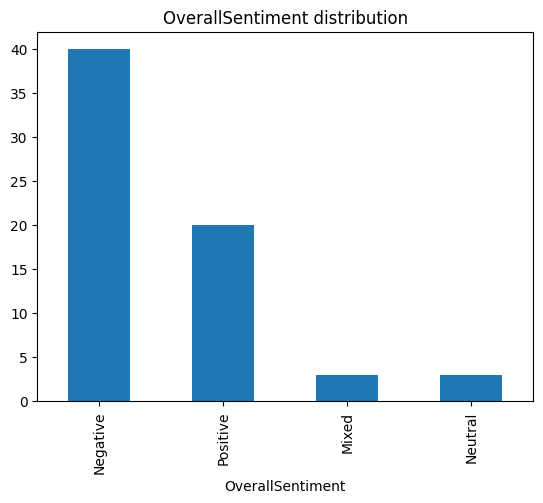

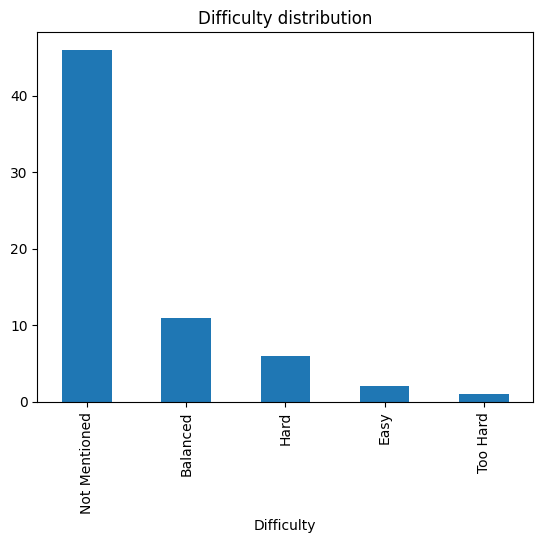

Recommended,0,1
OverallSentiment,,
Mixed,0,3
Negative,38,2
Neutral,2,1
Positive,0,20


In [29]:
df_structured["OverallSentiment"].value_counts().plot(kind="bar")
plt.title("OverallSentiment distribution")
plt.show()

df_structured["Difficulty"].value_counts().plot(kind="bar")
plt.title("Difficulty distribution")
plt.show()

ct = pd.crosstab(df_structured["OverallSentiment"], df_structured["Recommended"])
ct

In [30]:
pos = df_structured[["PositiveAspects"]].explode("PositiveAspects")["PositiveAspects"].dropna()
neg = df_structured[["NegativeAspects"]].explode("NegativeAspects")["NegativeAspects"].dropna()

print("Top PositiveAspects:")
display(pos.value_counts().head(10))

print("Top NegativeAspects:")
display(neg.value_counts().head(10))


Top PositiveAspects:


PositiveAspects
Interesting characters                            2
Not Mentioned                                     2
Intricate and organic city design                 1
Multiple paths in quests                          1
Engaging story and characters                     1
Atmosphere of the game                            1
High-tech lowlife futuristic cyberpunk setting    1
Solid graphics with max settings                  1
Beautiful setting                                 1
Fascinating story                                 1
Name: count, dtype: int64

Top NegativeAspects:


NegativeAspects
Numerous bugs and glitches                 3
Performance issues                         2
Lack of character customization            2
Game can be too easy                       1
Lack of proper closure in side quests      1
Not enough impact on the world             1
Game feels unfinished and rushed           1
Repetitive side quests                     1
Lack of character customization options    1
Punitive design philosophy                 1
Name: count, dtype: int64

### Inspector por RowId (cambia un número)

- Pon `INSPECT_ROWID` al `RowId` que quieras revisar.
- Verás la reseña original + el JSON extraído.


In [31]:

if "df_structured" in globals() and isinstance(df_structured, pd.DataFrame):
    _df = df_structured.copy()
elif "structured_results" in globals():
    _df = pd.DataFrame(structured_results).copy()
else:
    raise NameError("Need `df_structured` (DataFrame) or `structured_results` (list of dicts) in memory.")

# Normalize Id for matching
if "Id" not in _df.columns:
    raise KeyError("df_structured must contain column 'Id'.")

_df["Id_str"] = _df["Id"].astype(str).str.strip()

# Optional: keep only expected extraction columns if present (prevents clutter)
cols_order = ["Id", "Id_str", "OverallSentiment", "Difficulty", "Recommended", "PositiveAspects", "NegativeAspects"]
existing = [c for c in cols_order if c in _df.columns]
remaining = [c for c in _df.columns if c not in existing]
df_structured_ready = _df[existing + remaining]

print("df_structured_ready rows:", len(df_structured_ready))
display(df_structured_ready.head(3))


df_structured_ready rows: 66


,Id,Id_str,OverallSentiment,Difficulty,Recommended,PositiveAspects,NegativeAspects
0,17660,17660,Positive,Balanced,1,"[Intricate and organic city design, Multiple p...","[Game can be too easy, Lack of proper closure ..."
1,4187,4187,Negative,Not Mentioned,0,"[Atmosphere of the game, High-tech lowlife fut...","[Game feels unfinished and rushed, Repetitive ..."
2,5415,5415,Negative,Hard,0,"[Beautiful setting, Fascinating story, Interes...","[Punitive design philosophy, Unrewarding boss ..."


In [34]:
# --- CONFIG ---
SOURCE_DF = df_relevant
MODE = "pos"           # "rowid" or "pos"

# --- Change this to compare reviews with extraction notes ---
VALUE = 1

# --- checks ---
if "df_structured_ready" not in globals():
    raise NameError("Run Cell 1 first to create df_structured_ready.")
if not isinstance(SOURCE_DF, pd.DataFrame):
    raise TypeError("SOURCE_DF must be a pandas DataFrame (e.g., df_relevant or df_top_clean).")
for col in ["RowId", "Contenido"]:
    if col not in SOURCE_DF.columns:
        raise KeyError(f"SOURCE_DF must contain '{col}' column.")

src = SOURCE_DF.copy()
src["RowId_str"] = src["RowId"].astype(str).str.strip()

# Resolve RowId to inspect
if MODE == "pos":
    if VALUE < 0 or VALUE >= len(src):
        display(Markdown(f"❌ Position out of range: {VALUE} (0..{len(src)-1})"))
        raise SystemExit
    row_src = src.iloc[VALUE]
    rid = row_src["RowId_str"]
    display(Markdown(f"## 🔎 Inspect by POSITION `{VALUE}` → RowId `{rid}`"))
elif MODE == "rowid":
    rid = str(VALUE).strip()
    m = src[src["RowId_str"] == rid]
    if m.empty:
        display(Markdown(f"❌ RowId `{rid}` not found in SOURCE_DF"))
        raise SystemExit
    row_src = m.iloc[0]
    display(Markdown(f"## 🔎 Inspect by RowId `{rid}`"))
else:
    raise ValueError("MODE must be 'rowid' or 'pos'.")

# Find extraction
ext = df_structured_ready.copy()
mext = ext[ext["Id_str"] == rid]

# Show original
display(Markdown("### 📝 Original review"))
display(Markdown(f"> {row_src['Contenido']}"))

# Show extraction
if mext.empty:
    display(Markdown(f"❌ **No extraction found for RowId `{rid}`**"))
else:
    row_ext = mext.iloc[0].to_dict()
    display(Markdown("### 📦 Extraction"))
    display({
        "Id": row_ext.get("Id"),
        "OverallSentiment": row_ext.get("OverallSentiment"),
        "Difficulty": row_ext.get("Difficulty"),
        "Recommended": row_ext.get("Recommended"),
        "PositiveAspects": row_ext.get("PositiveAspects"),
        "NegativeAspects": row_ext.get("NegativeAspects"),
    })

## 🔎 Inspect by POSITION `1` → RowId `4187`

### 📝 Original review

> oh well admittedly its difficult for to write this review let start by saying that i was and kind of still am pretty biased regarding cdpr and their games and thats why its painful to admit and accept the fact that in its current state cp 2077 is very dissapointing by cdpr standards and in general as wellim huge fantasy and rpg fan and with the witcher trilogy cdpr created one of my favorite gaming franchises i loved all 3 witcher games thronebreaker played gwent on gog for dozens of hours and all of them are entertaining quality content rich titles so my personal experiences with their previous products the countless hours i invested in them and the enjoyment i got out of them pretty much made cdpr my favorite developer studio and they even topped it with their attitude towards their community and the continous support they provide to their games patches and fixes years after release free dlcs paid expansions with incredible amount of contentas lot of other gamers i highly anticipated cp 2077 i had pretty solid idea what to expect i was familiar with previous cdpr titles and i knew it will be heavily text and dialogue based rpg and did not expect fastpaced futuristic fps gta or whatever so im not one of those who compare it to gta v screen by screen neither i complain about the amount of dialogues or the slowburning storyfurthermore i consciously didnt sit on the hypetrain like lot of dumbasses i didnt expect this game to be some kind of miracle that would bring groundbreaking neverbeforeseen innovations in its every aspect and would revolutionize the gaming industry forever i remembered the buggy state in which the witcher 3 was released so i expected to encounter bugs as well my point is that i had pretty high but not unrealistic hopes and expectations for cyberpunk 2077i knew it wouldnt be able to live to the unbelievable hype that was generated around it but cdpr can only be partly blamed for that the unrealistic hype was mostly generated by gaming portals and journalists i do not wish to go into detail about the state of todays gaming journalism and the quality it represents because its ridiculous and pathetic beyond measure and the highly toxic gaming community itself id love to address this as well and share my opinion but i could rant on and on about this for hours but lets just say that its just sad that in 2020 its common that developers receive deaththreaths over the delay of videogame by some basementdweller pathetic nerd get life dudeso lets talk about the gameso far i have played for around 60 hours and i still havent finished the story but i usually take my time in rpgs and complete every sidequest explore everything that i can etc so thats normal i guess its true that you can rush through the story under 1520 hours but who in their right minds would do that in any rpg initially i didnt encounter that many bugs only few barely noticable graphical glitches but nothing gamebreaking the game only crashed once over the span of 60 hours and i had pretty stable performance and smooth experience with my rtx 2080 but bugs became more frequent and severe as i played more besides the mentioned graphical glitches ive seen wierd animations missing textures cars disappearing and popping out of nowhere cars falling from the sky quests that can not be finished unlootable items and so onthe hotfixes didnt bring that much improvement at least regarding those bugs that i experienced but based on the state the witcher 3 was released and the one it is in now im sure all of these will be resolved with the upcoming patches in the next monthsthe graphics are pretty solid with max settings the city looks great the characters sometimes are less so but its appealing to look at its nothing jawdropping and thats totally fine by its very sad when someone thinks that good graphics good game i definitely love the atmosphere of the game the hightech lowlife futuristic cyberpunk setting is great you can feel the strong bladerunner influence and the great music and soundtrack complements the atmosphere very wellmoving on to the story as i said i havent finished it yet so i cant form an opinion about it in its entirety buts its kind of letdown so far its not the worst i wouldnt even say its bad sadly its just not that interesting to make want to get to the end of it and it doesnt help that that the first 1015 main quests and the story they cover have been spoiled by the trailers before release some of the sidequests are more interesting than the main story but the other gigs and jobs become just dull and repetitive quicklymy main problem is that cyberpunk 2077 lacks lot of mechanics that in my opinion would be must in such worldsetting character customization is not that bad as some say there are plenty of options but i have to agree that i have seen far more detailed customization possibilites in other games ok you can choose the color of your teeth the size and shape of your but whats the purpose you cant even see your character outside of the inventory screen not even during sex sequencesin world where body modification is not just possible but pretty much common thing with cyberware implants etc and where looks in general are above all else the fact that you cant alter your appearance later on during the game is just pathetic you cant even get haircut which is pretty much inexcusable nowadays especially that even the witcher 3 offered such possibilitessince cyberpunk 2077 is an rpg your clothes and equipment obv provide stat boosts if you want to use items that provide better stats you constantly have to change them and because of that most of the time your appearance is ridiculous and you look like homeless who dresses from lost and found bin why isnt there an option to change the looks of your clothes while keeping the new stats lot of other games utilize such functionality transmogrification and even tough this is not fantasy rpg changing the appearance of clothes can be easily explained in scifi setting as well for example with some kind of holographic technology or whateveranother big problem is that sadly there is not much to do in night city there are plenty of sidequests which are fine you have tons of gigs and other sidejobs but these jobs are almost identical apprehend or kill cyberpsycho kill some gang members here and there retrieve some intel from somewhere etc and they become repetitive very quickly and besides this there is nothing there are few collectibles you can buy cars and motorcycles there few races and underground fighting pits or something like that and with that we are at the end of the listonce again id like to mention that i know this is not sandbox action game its an openworld rpg i dont want to play pool or bowling or things like that like some peep mentioned comparing it to gta v but in 2020 i expected more it was emphasized that sex and sexual themes are very important well besides some romance options during sidequests there is 1 female and 1 male prostitue in night city on the same street you can bang them and thats it you cant even go to strip clubs or anything like thatjust to mention the driving i dont think its as bad as some say i didnt really have any problems with the controls or mechanics besides that the first person view is useless d but then again im not really into driving games and driving mechanics are just do not matter to in generali expected solid rpg but at the moment cp2077 feels unfinished rushed buggy and just very average which is nowhere near the usual cdpr quality and sadly i cant recommend it you should wait at least 1 year or half and check back then

### 📦 Extraction

{'Id': '4187',
 'OverallSentiment': 'Negative',
 'Difficulty': 'Not Mentioned',
 'Recommended': '0',
 'PositiveAspects': ['Atmosphere of the game',
  'High-tech lowlife futuristic cyberpunk setting',
  'Solid graphics with max settings'],
 'NegativeAspects': ['Game feels unfinished and rushed',
  'Repetitive side quests',
  'Lack of character customization options']}

## 6) Exportación del resultado

Exportamos un CSV con timestamp para evitar sobreescrituras.


In [35]:
ts = time.strftime("%Y%m%d-%H%M%S")
out_path = Path(f"output/analisis_videojuegos_resultados_{ts}.csv")
out_path.parent.mkdir(parents=True, exist_ok=True)
df_structured.to_csv(out_path, index=False)
out_path

PosixPath('output/analisis_videojuegos_resultados_20260208-195105.csv')